# 0.0. __INIT__

## 0.1. Imports

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

from sklearn import ensemble as en
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import mixture as mx
from sklearn.manifold import TSNE
from sklearn import cluster
from sklearn import metrics

from scipy.cluster import hierarchy as hc

import pymc3 as pymc

/Users/jeova.ramos/jeova/desafio_bornlogic/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.2. Helper Functions

In [325]:
PXChart = px._chart_types


def numerical_description(numerical: pd.DataFrame) -> pd.DataFrame:
    description = numerical.describe().T
    description['range'] = description['max'] - description['min']
    description['skew'] = numerical.skew()
    description['kurtosis'] = numerical.kurtosis()

    return description


def plot_histogram(data: pd.DataFrame, column: str) -> None:
    fig = px.histogram(data, x=column)
    fig = fig.update_layout(
        title_text=f'{snake_to_text(column)} histogram',
        xaxis_title_text='Value',
        yaxis_title_text='Count')
    fig.show()


def plot_xy(data: pd.DataFrame, x_axis: str, y_axis: str, plot_type: PXChart) -> None:
    fig = plot_type(data, x=x_axis, y=y_axis)
    fig = fig.update_layout(
        title_text=f'{snake_to_text(y_axis)}',
        xaxis_title_text=snake_to_text(x_axis),
        yaxis_title_text='Value')
    fig.show()


def snake_to_text(string: str) -> str:
    return string.capitalize().replace("_", " ")


def get_region(data: pd.DataFrame, country: str) -> str:
    try:
        region = data[data["country_name"] == country]["regional_indicator"].values[0]
    except IndexError:
        region = "NOT_DEFINED"

    return region


def plot_comparison(trace: pymc.backends.base.MultiTrace, title: str, len_data: int) -> None:
    plt.figure(figsize=(5, 5))
    plt.suptitle(title)

    plt.subplot(311)
    plt.hist(trace["lambda_1"], histtype="stepfilled", bins=30, density=True)
    plt.xlim([0, 3])

    plt.subplot(312)
    plt.hist(trace["lambda_2"], histtype="stepfilled", bins=30, density=True)
    plt.xlim([0, 3])

    plt.subplot(313)
    weights = 1.0 / len(trace['tau']) * np.ones_like(trace['tau'])
    plt.hist(trace["tau"], histtype="stepfilled", bins=len_data, weights=weights, rwidth=2.)
    plt.xlim([0, len_data])
    plt.ylim([0, 1.0])

    plt.show()


def bayesian_inference(df_average: pd.DataFrame, region: str, variable: str) -> pymc.backends.base.MultiTrace:
    df_regional = df_average[df_average["regional_indicator"] == region]

    response_variable = df_regional[variable].values.ravel()
    len_data = len(response_variable)
    with pymc.Model():

        # Prior
        alpha = 1.0 / response_variable.mean()
        lambda_1 = pymc.Exponential("lambda_1", alpha)
        lambda_2 = pymc.Exponential("lambda_2", alpha)

        tau = pymc.DiscreteUniform("tau", lower=0, upper=len_data - 1)

        # Posterior
        idx = np.arange(len_data)
        lambda_ = pymc.math.switch(tau > idx, lambda_1, lambda_2)
        _ = pymc.Poisson("obs", lambda_, observed=response_variable)

        # Likelihood
        trace = pymc.sample(
            draws=10_000, tune=5_000, step=pymc.Metropolis(), return_inferencedata=False)

        return trace, len_data


## 0.3. Loading data

In [3]:
data_metrics = pd.read_excel("data/Data_2021.xls")
data_historic = pd.read_excel("data/Historic_data.xls")

# 1.0. DATA DESCRIPTION

In [4]:
df1_metrics = data_metrics.copy()
df1_historic = data_historic.copy()

## 1.1. Metrics description

In [5]:
df1_metrics.head()

,Country name,Regional indicator,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,Finland,Western Europe,7.8421,10.775202,0.953603,72.000000,0.949268,-0.097760,0.185846
1,Denmark,Western Europe,7.6195,10.933176,0.954410,72.699753,0.945639,0.030109,0.178838
2,Switzerland,Western Europe,7.5715,11.117368,0.941742,74.400101,0.918788,0.024629,0.291698
3,Iceland,Western Europe,7.5539,10.877768,0.982938,73.000000,0.955123,0.160274,0.672865
4,Netherlands,Western Europe,7.4640,10.931812,0.941601,72.400116,0.913116,0.175404,0.337938


### 1.1.0. Renaming columns

In [6]:
df1_metrics.columns = [name.lower().replace(" ", "_") for name in df1_metrics.columns]

### 1.1.1. Data Dimensions

In [7]:
print(f'Number of rows: {df1_metrics.shape[0]}')
print(f'Number of columns: {df1_metrics.shape[1]}')

Number of rows: 149
Number of columns: 9


### 1.1.2. Data types

In [8]:
df1_metrics.dtypes

country_name                     object
regional_indicator               object
ladder_score                    float64
logged_gdp_per_capita           float64
social_support                  float64
healthy_life_expectancy         float64
freedom_to_make_life_choices    float64
generosity                      float64
perceptions_of_corruption       float64
dtype: object

### 1.1.3. Check NA

In [9]:
df1_metrics.isna().sum()

country_name                    0
regional_indicator              0
ladder_score                    0
logged_gdp_per_capita           0
social_support                  0
healthy_life_expectancy         0
freedom_to_make_life_choices    0
generosity                      0
perceptions_of_corruption       0
dtype: int64

### 1.1.4. Fillout NA

In [10]:
# There is no NA
pass

### 1.1.5 Change types

In [11]:
# Not needed
pass

### 1.1.6. Descriptive Statistical

In [12]:
numerical = df1_metrics.select_dtypes(include=['int64', 'float64'])
categorical = df1_metrics.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.1.6.1. Numerical attributes

In [13]:
numerical_description(numerical)

,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
ladder_score,149.0,5.532832,1.073923,2.522900,4.851800,5.533500,6.255400,7.842100,5.319200,-0.104272,-0.368236
logged_gdp_per_capita,149.0,9.432209,1.158585,6.635322,8.540956,9.568728,10.421198,11.646564,5.011242,-0.352070,-0.815365
social_support,149.0,0.814726,0.114892,0.462596,0.749777,0.831914,0.904702,0.982938,0.520342,-0.937962,0.398104
healthy_life_expectancy,149.0,64.992784,6.762071,48.478001,59.801552,66.603096,69.599998,76.952858,28.474857,-0.522006,-0.564196
freedom_to_make_life_choices,149.0,0.791572,0.113315,0.381749,0.718051,0.804414,0.877263,0.970131,0.588382,-0.756627,0.412602
generosity,149.0,-0.015149,0.150653,-0.288153,-0.126469,-0.036025,0.078830,0.541553,0.829706,1.009203,1.631913
perceptions_of_corruption,149.0,0.727477,0.179266,0.081959,0.666607,0.780623,0.844619,0.939343,0.857385,-1.576883,2.248839


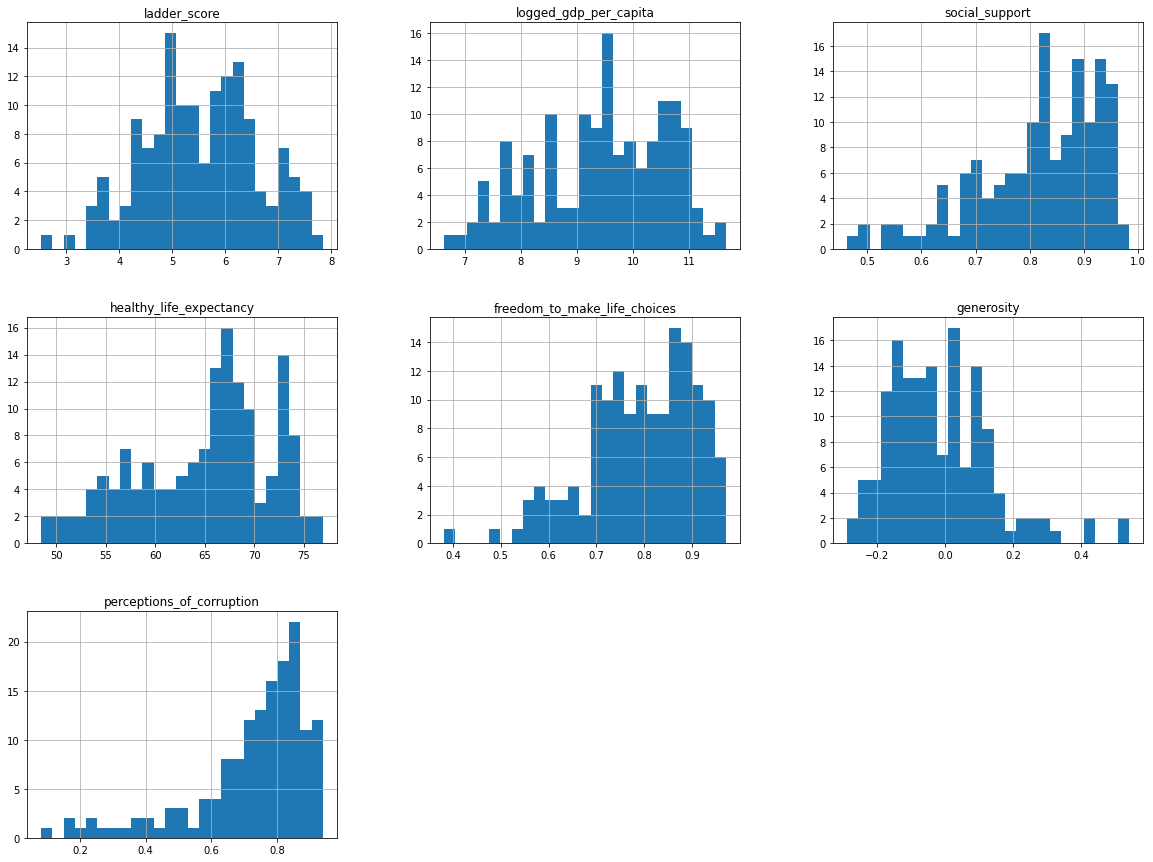

In [14]:
numerical.hist(bins=25, figsize=(20, 15));

#### 1.1.6.2. Categorical attributes

In [15]:
# Checking how many categories in each column
categorical.apply(lambda x: x.unique().shape[0])

country_name          149
regional_indicator     10
dtype: int64

In [17]:
# Bar plot for smallest granularity
for numerical_variable in numerical.columns:
    df_auxiliar = df1_metrics.sort_values(numerical_variable)
    plot_xy(df_auxiliar, x_axis="country_name", y_axis=numerical_variable, plot_type=px.bar)

In [18]:
for numerical_variable in numerical.columns:
    df_auxiliar = df1_metrics.sort_values(numerical_variable)
    plot_xy(df_auxiliar, x_axis="regional_indicator", y_axis=numerical_variable, plot_type=px.box)

## 1.2. Historic description

In [19]:
df1_historic.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.723590,7.370100,0.450662,50.799999,0.718114,0.167640,0.881686,0.517637,0.258195
1,Afghanistan,2009,4.401778,7.539972,0.552308,51.200001,0.678896,0.190099,0.850035,0.583926,0.237092
2,Afghanistan,2010,4.758381,7.646709,0.539075,51.599998,0.600127,0.120590,0.706766,0.618265,0.275324
3,Afghanistan,2011,3.831719,7.619532,0.521104,51.919998,0.495901,0.162427,0.731109,0.611387,0.267175
4,Afghanistan,2012,3.782938,7.705479,0.520637,52.240002,0.530935,0.236032,0.775620,0.710385,0.267919


### 1.2.0. Rename columns

In [20]:
df1_historic.columns = [name.lower().replace(" ", "_") for name in df1_historic.columns]

### 1.2.1. Data Dimensions

In [21]:
print(f'Number of rows: {df1_historic.shape[0]}')
print(f'Number of columns: {df1_historic.shape[1]}')

Number of rows: 1949
Number of columns: 11


### 1.2.2. Data types

In [22]:
df1_historic.dtypes

country_name                         object
year                                  int64
life_ladder                         float64
log_gdp_per_capita                  float64
social_support                      float64
healthy_life_expectancy_at_birth    float64
freedom_to_make_life_choices        float64
generosity                          float64
perceptions_of_corruption           float64
positive_affect                     float64
negative_affect                     float64
dtype: object

### 1.2.3. Check NA

In [23]:
df1_historic.isna().sum()

country_name                          0
year                                  0
life_ladder                           0
log_gdp_per_capita                   36
social_support                       13
healthy_life_expectancy_at_birth     55
freedom_to_make_life_choices         32
generosity                           89
perceptions_of_corruption           110
positive_affect                      22
negative_affect                      16
dtype: int64

In [24]:
number_of_countries = df1_historic["country_name"].unique().shape[0]
df_auxiliar = df1_historic.groupby("year").count() / number_of_countries * 100
df_auxiliar.sort_values("year").reset_index()

,year,country_name,life_ladder,log_gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect
0,2005,16.265060,16.265060,16.265060,16.265060,16.265060,15.060241,0.602410,15.060241,15.662651,15.662651
1,2006,53.614458,53.614458,53.012048,53.614458,53.012048,51.807229,48.795181,50.000000,53.614458,53.012048
2,2007,61.445783,61.445783,61.445783,60.240964,60.843373,60.843373,61.445783,59.036145,60.843373,61.445783
3,2008,66.265060,66.265060,66.265060,66.265060,65.060241,64.457831,65.662651,64.457831,65.060241,66.265060
4,2009,68.674699,68.674699,68.072289,68.072289,66.867470,67.469880,68.072289,66.867470,68.072289,68.072289
5,2010,74.698795,74.698795,74.096386,72.289157,72.891566,73.493976,74.096386,71.686747,72.289157,72.289157
6,2011,87.951807,87.951807,87.349398,87.349398,84.939759,87.349398,86.746988,83.132530,87.349398,87.951807
7,2012,85.542169,85.542169,84.337349,85.542169,81.927711,84.939759,80.120482,79.518072,85.542169,85.542169
8,2013,82.530120,82.530120,81.927711,82.530120,80.120482,81.927711,80.120482,78.313253,81.325301,82.530120
9,2014,87.349398,87.349398,85.542169,85.542169,84.337349,83.132530,83.132530,81.927711,84.939759,85.542169


In [25]:
number_of_years = df1_historic["year"].unique().shape[0]
df_auxiliar = df1_historic.groupby("country_name").count() / number_of_years * 100
df_auxiliar.sort_values("positive_affect").reset_index()

,country_name,year,life_ladder,log_gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect
0,Maldives,6.25,6.25,6.25,6.25,6.25,6.25,6.25,0.00,0.00,0.00
1,Oman,6.25,6.25,6.25,0.00,6.25,6.25,6.25,0.00,0.00,6.25
2,Cuba,6.25,6.25,0.00,6.25,6.25,6.25,0.00,0.00,6.25,6.25
3,Guyana,6.25,6.25,6.25,6.25,6.25,6.25,6.25,6.25,6.25,6.25
4,Suriname,6.25,6.25,6.25,6.25,6.25,6.25,6.25,6.25,6.25,6.25
...,...,...,...,...,...,...,...,...,...,...,...
161,South Korea,93.75,93.75,93.75,93.75,93.75,93.75,87.50,93.75,93.75,93.75
162,Spain,93.75,93.75,93.75,93.75,93.75,93.75,87.50,93.75,93.75,93.75
163,Georgia,93.75,93.75,93.75,93.75,93.75,93.75,93.75,93.75,93.75,93.75
164,Russia,93.75,93.75,93.75,93.75,93.75,93.75,93.75,93.75,93.75,93.75


### 1.2.4. Fillout NA

In [26]:
# For simplicity and considering that skew observed in section 1.2.6.1. e 1.2.6.2.
# # -> Using median
not_filled_df = df1_historic.copy()
for column in df1_historic.columns[1:]:
    df1_historic[column].fillna(df1_historic[column].median(), inplace=True)

In [27]:
df1_historic.isna().sum()

country_name                        0
year                                0
life_ladder                         0
log_gdp_per_capita                  0
social_support                      0
healthy_life_expectancy_at_birth    0
freedom_to_make_life_choices        0
generosity                          0
perceptions_of_corruption           0
positive_affect                     0
negative_affect                     0
dtype: int64

### 1.2.5 Change types

In [28]:
# Not needed
pass

### 1.2.6. Descriptive Statistical

In [29]:
numerical = df1_historic.select_dtypes(include=['int64', 'float64'])
categorical = df1_historic.select_dtypes(exclude=['float64', 'datetime64[ns]'])  # Excluded int64

#### 1.2.6.1. Numerical attributes

In [30]:
numerical_description(numerical)

,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
year,1949.0,2013.216008,4.166828,2005.000000,2010.000000,2013.000000,2017.000000,2020.000000,15.000000,-0.128238,-1.077674
life_ladder,1949.0,5.466707,1.115717,2.375092,4.640079,5.386025,6.283498,8.018934,5.643842,0.068491,-0.688600
log_gdp_per_capita,1949.0,9.370155,1.143444,6.635322,8.478379,9.460323,10.335316,11.648169,5.012846,-0.315749,-0.821982
social_support,1949.0,0.812704,0.118099,0.290184,0.750738,0.835167,0.904971,0.987343,0.697159,-1.117841,1.216308
healthy_life_expectancy_at_birth,1949.0,63.411317,7.409737,32.299999,58.900002,65.199997,68.400002,77.099998,44.799999,-0.773842,0.043662
freedom_to_make_life_choices,1949.0,0.742910,0.140957,0.257534,0.649316,0.763476,0.853534,0.985178,0.727644,-0.635143,-0.074113
generosity,1949.0,-0.001056,0.158561,-0.335040,-0.106459,-0.025393,0.084833,0.698099,1.033139,0.846856,1.040651
perceptions_of_corruption,1949.0,0.750233,0.181891,0.035198,0.698808,0.802428,0.867640,0.983276,0.948078,-1.578747,2.185235
positive_affect,1949.0,0.710138,0.106508,0.321690,0.627351,0.722391,0.797785,0.943621,0.621931,-0.369953,-0.555219
negative_affect,1949.0,0.268466,0.084830,0.082737,0.206641,0.258117,0.319231,0.704590,0.621853,0.743382,0.899204


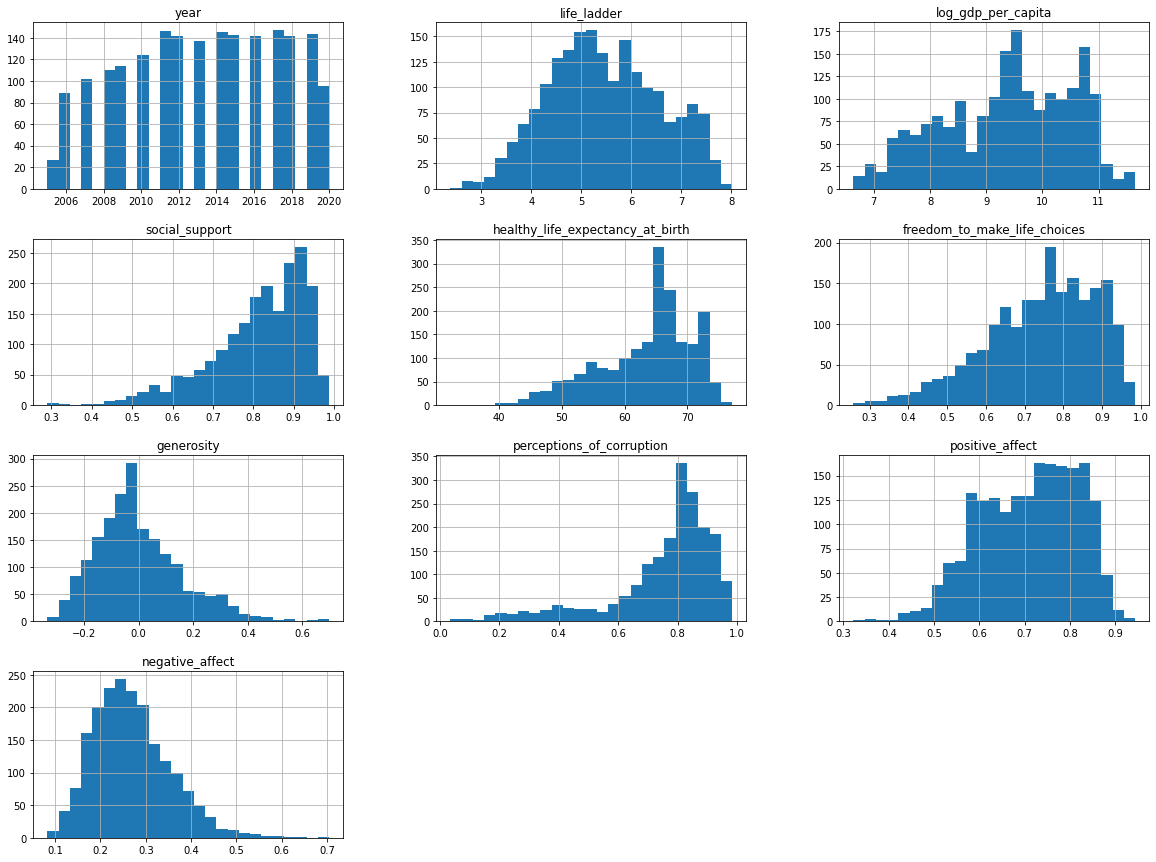

In [31]:
numerical.hist(bins=25, figsize=(20, 15));

#### 1.2.6.2. Categorical attributes

In [32]:
# Checking how many categories in each column
categorical.apply(lambda x: x.unique().shape[0])

country_name    166
year             16
dtype: int64

In [33]:
# Bar plot for smallest granularity
for numerical_variable in numerical.columns[1:]:  # To exclude "year" column
    df_auxiliar = df1_historic.sort_values(numerical_variable)
    plot_xy(df_auxiliar, x_axis="country_name", y_axis=numerical_variable, plot_type=px.box)

# 2.0. FEATURE ENGENEERING

In [34]:
df2_metrics = df1_metrics.copy()
df2_historic = df1_historic.copy()

In [35]:
df2_historic.sort_values("year").year.unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020])

## 2.1. Questions

1. O propósito é demonstrar para a alta cúpula a estimativa da felicidade média de um país através de métricas quantificáveis de desenvolvimento humano.

2. É possível identificar a região do mundo em que um país se encontra através da relação entre as métricas e o índice de felicidade obtido?

- Independente da afirmação - ou não - da pergunta, explique e justifique sua resposta;
- Se a resposta for negativa, existe alguma outra forma de identificar a região do mundo de um país?

3. Que tal pensar fora da caixa dos dados disponíveis? A pandemia causou algum impacto nos índices obtidos da felicidade mundial?


## 2.3. Featuring engineering

For simplicity, I'm taking the feature "Positive affect" as the response variable. This feature reflect the closest definition of happiness. So, there is no need to derivate other feature.

But, to answer the second question, we will need to use the "Regional indicator" feature.

In [36]:
regional_column = list()
for ii in range(len(df2_historic)):
    country = df2_historic["country_name"][ii]
    region = get_region(df2_metrics, country)
    
    regional_column.append(region)

df2_historic["regional_indicator"] = regional_column
df2_historic.head()

,country_name,year,life_ladder,log_gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,regional_indicator
0,Afghanistan,2008,3.723590,7.370100,0.450662,50.799999,0.718114,0.167640,0.881686,0.517637,0.258195,South Asia
1,Afghanistan,2009,4.401778,7.539972,0.552308,51.200001,0.678896,0.190099,0.850035,0.583926,0.237092,South Asia
2,Afghanistan,2010,4.758381,7.646709,0.539075,51.599998,0.600127,0.120590,0.706766,0.618265,0.275324,South Asia
3,Afghanistan,2011,3.831719,7.619532,0.521104,51.919998,0.495901,0.162427,0.731109,0.611387,0.267175,South Asia
4,Afghanistan,2012,3.782938,7.705479,0.520637,52.240002,0.530935,0.236032,0.775620,0.710385,0.267919,South Asia


# 3.0. DATA FILTERING

In [37]:
df3_metrics = df2_metrics.copy()
df3_historic = df2_historic.copy()

## 3.1. Lines filtering

In [38]:
# It will not remove any pandemics year
df3_historic = df3_historic[df3_historic["regional_indicator"] != "NOT_DEFINED"]

## 3.2. Columns filtering

In [39]:
# Keeping all of the columns
pass

# 4.0. EXPLORATORY DATA ANALISYS (EDA)

In [40]:
df4_metrics = df3_metrics.copy()
df4_historic = df3_historic.copy()

## 4.1. Metrics EDA

### 4.1.0. Profiling

In [41]:
metrics_historic = ProfileReport(df4_historic, title="Metrics Dataset Profiling Report", explorative=True)
# metrics_historic.to_file("report_metrics.html")

### 4.1.1. Univariate Analysis

#### 4.1.1.1. Response Variable

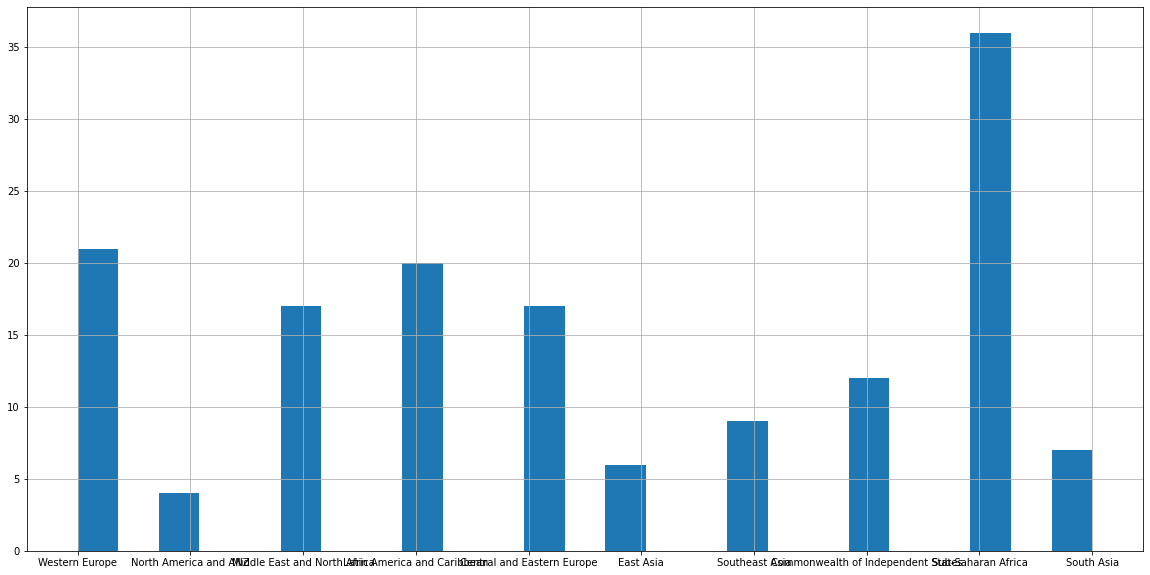

In [42]:
df4_metrics["regional_indicator"].hist(bins=25, figsize=(20, 10));

#### 4.1.1.2. Numerical Variables

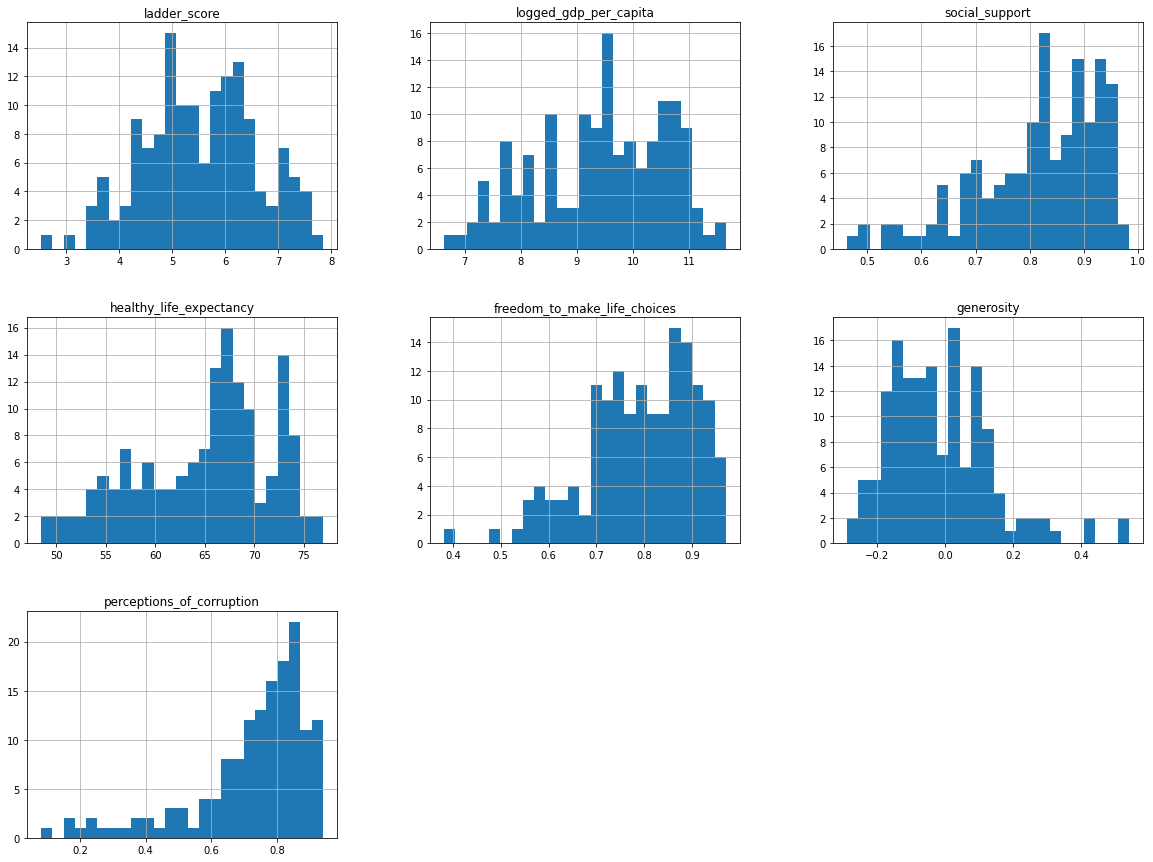

In [43]:
# The main point of seeing this again is to keep in mind what features
# may need a transformation in their distribution for better ML results
df4_metrics.hist(bins=25, figsize=(20, 15));

### 4.1.3. Categorical Variables

In [44]:
# Ignoring
pass

### 4.1.4. Bivariate Analysis

#### 4.1.4.1. Correlation checking

In [45]:
# Correlation Matrix
numerical = df4_metrics.select_dtypes(include=['float64'])
correlations = numerical.corr()
px.imshow(correlations, zmin=-1, zmax=1, color_continuous_scale=px.colors.diverging.RdBu)

In [46]:
# Pair plot visualization
numerical = df4_metrics.select_dtypes(include=['float64'])
fig = px.scatter_matrix(numerical, height=1280, width=1280)
fig.show()

### 4.1.5 Embedding space

In [357]:
df4_5 = df4_metrics.copy()
df4_5 = df4_metrics.drop(columns=["country_name"], axis=1)

#### 4.1.5.1. Data preparation

In [358]:
df4_5.dtypes

regional_indicator               object
ladder_score                    float64
logged_gdp_per_capita           float64
social_support                  float64
healthy_life_expectancy         float64
freedom_to_make_life_choices    float64
generosity                      float64
perceptions_of_corruption       float64
dtype: object

In [359]:
mm = pp.MinMaxScaler()
for variable in df4_5.columns[1:-1]:  # Numerical columns
    df4_5[variable] = mm.fit_transform(df4_5[[variable]])

df4_5["regional_indicator"] = pp.LabelEncoder().fit_transform(df4_5[["regional_indicator"]].values.ravel())

# df4_5 = pd.get_dummies(df4_5, prefix='', columns=['regional_indicator'])
df4_5.head()

,regional_indicator,ladder_score,logged_gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption
0,9,1.000000,0.826118,0.943625,0.826062,0.964542,0.229470,0.185846
1,9,0.958152,0.857642,0.945174,0.850636,0.958373,0.383584,0.178838
2,9,0.949128,0.894398,0.920829,0.910350,0.912739,0.376979,0.291698
3,9,0.945819,0.846586,1.000000,0.861181,0.974492,0.540465,0.672865
4,9,0.928918,0.857370,0.920558,0.840114,0.903098,0.558701,0.337938


#### 4.1.5.2. PCA

In [360]:
X = df4_5.drop(columns=['regional_indicator'], axis=1)
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

# pca component
df_pca = pd.DataFrame( principal_components )

In [361]:
# Components visualization
evr_data = [{"Value": evr} for evr in pca.explained_variance_ratio_]
evr_data = pd.DataFrame(evr_data)
px.bar(evr_data)

#### 4.1.5.3. PCA embbeding space

In [362]:
reducer = TSNE(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_tsne = pd.DataFrame()
df_tsne["regional_indicator"] = df4_metrics["regional_indicator"]
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot TSNE
px.scatter(df_tsne, x='embedding_x', y='embedding_y', color="regional_indicator")

/Users/jeova.ramos/jeova/desafio_bornlogic/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/jeova.ramos/jeova/desafio_bornlogic/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



#### 4.2.5.4. Random Forest

In [363]:
X = df4_5.drop(columns=['regional_indicator'], axis=1)
y = df4_5['regional_indicator']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf 
df_leaf = pd.DataFrame(rf_model.apply(X))

#### 4.1.5.5. Random Forest embbeding space

In [364]:
reducer = TSNE(random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tsne = pd.DataFrame()
df_tsne["regional_indicator"] = df4_metrics["regional_indicator"]
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot TSNE
px.scatter(df_tsne, x='embedding_x', y='embedding_y', color="regional_indicator")

/Users/jeova.ramos/jeova/desafio_bornlogic/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/jeova.ramos/jeova/desafio_bornlogic/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



## 4.2. Historic EDA

### 4.2.0. Profiling

In [55]:
profile_historic = ProfileReport(df4_historic, title="Historic Dataset Profiling Report", explorative=True)
# profile_historic.to_file("report_historic.html")

### 4.2.1. Univariate Analysis

#### 4.2.1.1. Response Variable

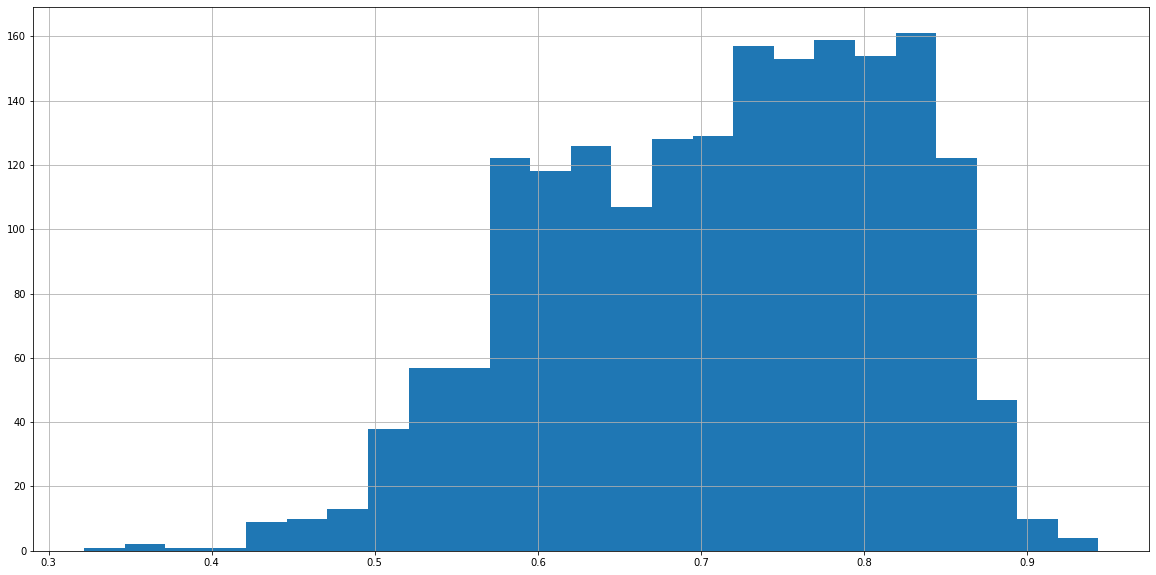

In [56]:
df4_historic["positive_affect"].hist(bins=25, figsize=(20, 10));

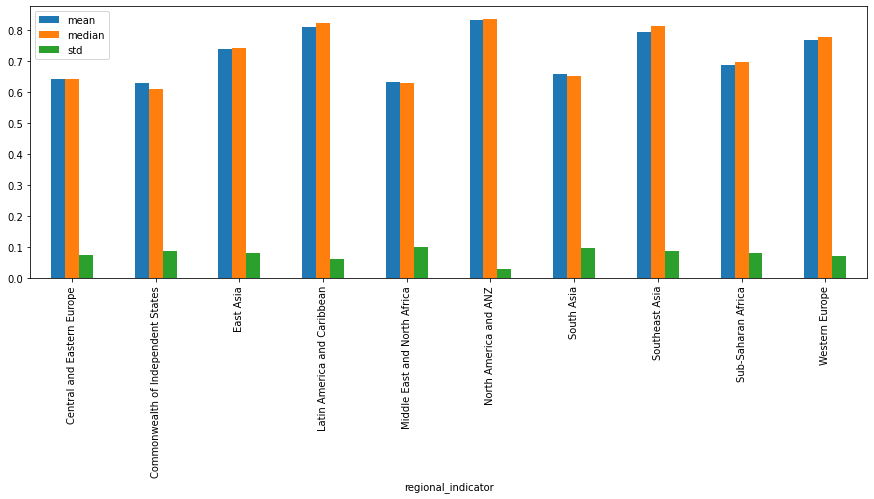

In [57]:
df4_historic.groupby("regional_indicator")["positive_affect"].agg(
    ["mean", "median", "std"]
).plot(kind="bar", figsize=(15, 5));

#### 4.2.1.2. Numerical Variables

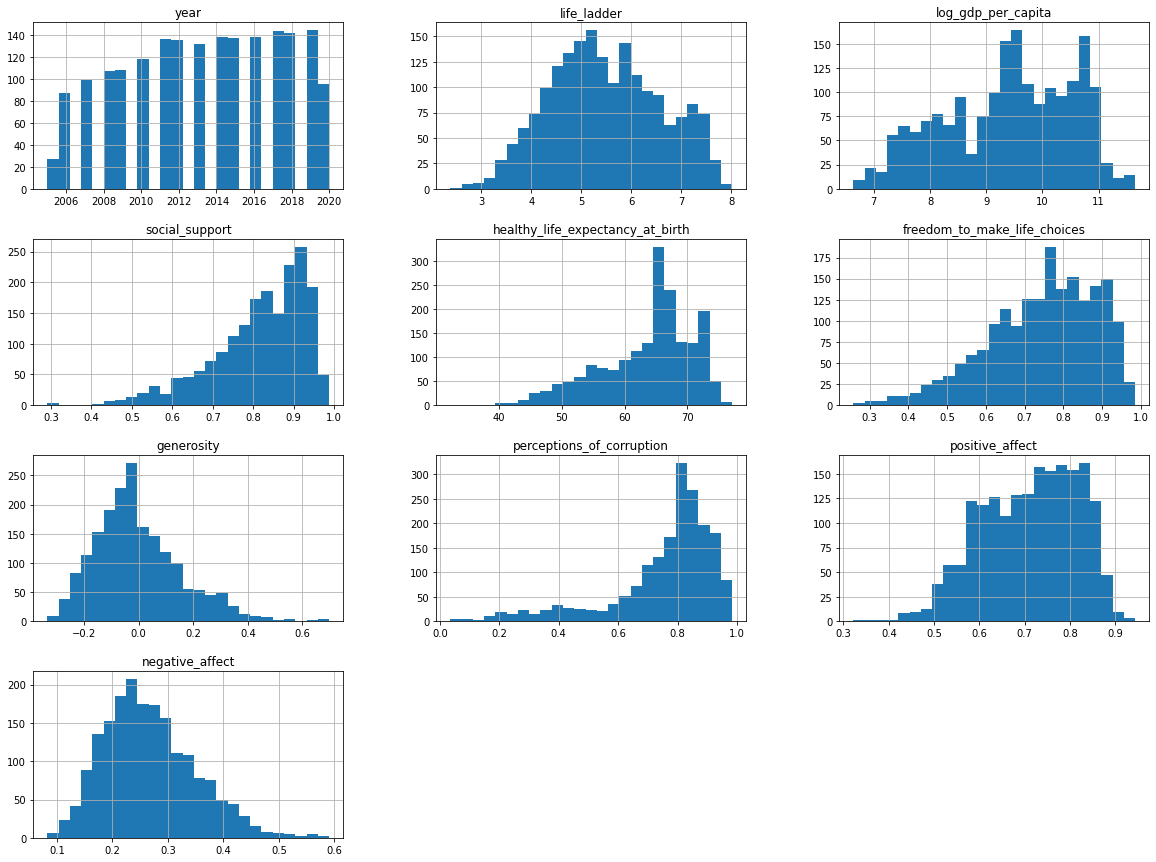

In [58]:
# The main point of seeing this again is to keep in mind what features
# may need a transformation in their distribution for better ML results
df4_historic.hist(bins=25, figsize=(20, 15));

### 4.2.3. Categorical Variables

In [59]:
# Ignoring
pass

### 4.2.4. Bivariate Analysis

#### 4.2.4.1. Correlation checking

In [60]:
# Correlation Matrix
numerical = df4_historic.select_dtypes(include=['float64'])
correlations = numerical.corr()
px.imshow(correlations, zmin=-1, zmax=1, color_continuous_scale=px.colors.diverging.RdBu)

In [61]:
# Pair plot visualization
numerical = df4_historic.select_dtypes(include=['float64'])
fig = px.scatter_matrix(numerical, height=1280, width=1280)
fig.show()

#### 4.2.4.2. Time evolution

In [62]:
df_sorted = df4_historic.sort_values("year").reset_index()
df_sorted = df_sorted.groupby(["year", "regional_indicator"]).mean().reset_index()
fig = px.line(df_sorted, x='year', y='positive_affect', color='regional_indicator')
fig.show()

### 4.2.5 Embedding space

In [365]:
df4_5 = df4_historic.copy()
df4_5 = df4_5.drop(columns=["country_name"], axis=1)

#### 4.2.5.1. Data preparation

In [366]:
df4_5.dtypes

year                                  int64
life_ladder                         float64
log_gdp_per_capita                  float64
social_support                      float64
healthy_life_expectancy_at_birth    float64
freedom_to_make_life_choices        float64
generosity                          float64
perceptions_of_corruption           float64
positive_affect                     float64
negative_affect                     float64
regional_indicator                   object
dtype: object

In [367]:
mm = pp.MinMaxScaler()
for variable in df4_5.columns[1:-1]:  # Numerical columns
    df4_5[variable] = mm.fit_transform(df4_5[[variable]])

df4_5["year"] = pp.OrdinalEncoder().fit_transform(df4_5[["year"]])
df4_5["regional_indicator"] = pp.LabelEncoder().fit_transform(df4_5[["regional_indicator"]].values.ravel())

# df4_5 = pd.get_dummies(df4_5, prefix='', columns=['regional_indicator'])
df4_5.head()

,year,life_ladder,log_gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,regional_indicator
0,3.0,0.238933,0.146579,0.229360,0.412946,0.632975,0.486556,0.892847,0.315063,0.345526,6
1,4.0,0.359097,0.180466,0.375317,0.421875,0.579078,0.508295,0.859462,0.421648,0.303968,6
2,5.0,0.422281,0.201759,0.356315,0.430804,0.470826,0.441015,0.708347,0.476863,0.379256,6
3,6.0,0.258091,0.196338,0.330509,0.437946,0.327588,0.481511,0.734022,0.465803,0.363208,6
4,7.0,0.249448,0.213483,0.329839,0.445089,0.375735,0.552755,0.780971,0.624981,0.364674,6


#### 4.2.5.2. PCA

In [373]:
X = df4_5.drop(columns=['regional_indicator'], axis=1)
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

# pca component
df_pca = pd.DataFrame( principal_components )

In [374]:
# Components visualization
evr_data = [{"Value": evr} for evr in pca.explained_variance_ratio_]
evr_data = pd.DataFrame(evr_data)
px.bar(evr_data)

#### 4.2.5.3. PCA embbeding space

In [375]:
reducer = TSNE(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_tsne = pd.DataFrame()
df_tsne["regional_indicator"] = df4_historic["regional_indicator"]
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
px.scatter(df_tsne, x='embedding_x', y='embedding_y', color="regional_indicator")

/Users/jeova.ramos/jeova/desafio_bornlogic/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/jeova.ramos/jeova/desafio_bornlogic/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



#### 4.2.5.4. Random Forest

In [376]:
X = df4_5.drop(columns=['regional_indicator'], axis=1)
y = df4_5['regional_indicator']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf 
df_leaf = pd.DataFrame(rf_model.apply(X))

#### 4.2.5.5. Random Forest embbeding space

In [378]:
reducer = TSNE(random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tsne = pd.DataFrame()
df_tsne["regional_indicator"] = df4_historic["regional_indicator"]
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
px.scatter(df_tsne, x='embedding_x', y='embedding_y', color="regional_indicator")

/Users/jeova.ramos/jeova/desafio_bornlogic/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/jeova.ramos/jeova/desafio_bornlogic/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



## Pergunta 1.
- **Demonstrar para a alta cúpula a estimativa da felicidade média de um país através de métricas quantificáveis de desenvolvimento humano.**

In [71]:
# Globe
df_mean = df2_metrics.groupby(
    ['country_name']).mean(['ladder_score']).reset_index()

fig = px.choropleth(
    df_mean, locations='country_name', locationmode="country names", 
    color='ladder_score', projection='orthographic', 
    color_continuous_scale=px.colors.sequential.Viridis,
    range_color=[0, 10],
    title="Positive affect index", 
)

fig.show()

In [72]:
variable = "generosity"

# df_mean = df2_historic.groupby(
#     ['year','country_name']).mean(
#     [variable]).reset_index()

df_sorted = df2_historic.sort_values("year").reset_index()
fig = px.choropleth(
    df_sorted, locations='country_name', locationmode="country names",
    color=variable, animation_frame='year',
    color_continuous_scale=px.colors.diverging.BrBG,
    range_color=[-1, 1],
    color_continuous_midpoint=0,
    title=f'{variable.capitalize()} time evolution'
)

fig.show()

In [73]:
variable = "positive_affect"

df_sorted = df2_historic.sort_values("year").reset_index()
fig = px.choropleth(
    df_sorted, locations='country_name', locationmode="country names",
    color=variable, animation_frame='year',
    color_continuous_scale=px.colors.sequential.Viridis,
    range_color=[0.4, 1],
    title=f'{variable.capitalize()} time evolution'
)

fig.show()

## **Pergunta 2.**
- **É possível identificar a região do mundo em que um país se encontra através da relação entre as métricas e o índice de felicidade obtido?**

Não é possível.

### Pergunda 2.1.
- **Justificativa da resposta**

Necessidade de informação geoespacial. Outro dataset para compor os disponibilizados.

### Pergunda 2.2.
- **Se a resposta for negativa, existe alguma outra forma de identificar a região do mundo de um país?**

## **Pergunta 3.** 
- **Que tal pensar fora da caixa dos dados disponíveis? A pandemia causou algum impacto nos índices obtidos da felicidade mundial?**

In [305]:
# Visualization for insights
df_average = df4_historic.groupby(
    ["year", "regional_indicator"]).median().sort_values("year").reset_index()

numerical = df4_historic.select_dtypes(include=['float64'])
for var in ["positive_affect", "negative_affect"]:
    fig = px.line(df_average, x="year", y=var, facet_col="regional_indicator",
                  facet_col_wrap=5, markers=True, title=f"Annual regional average of {snake_to_text(var)}")

    var_mean = df_average[var].mean()
    fig = fig.add_hline(y=var_mean, line_dash="dot",
                        annotation_text="Global average",
                        annotation_position="bottom right")

    fig = fig.add_vrect(x0=2019.5, x1=2020.5,
                        annotation_text="Pandemic", annotation_position="top left",
                        fillcolor="green", opacity=0.25, line_width=0)
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    fig.show()


### Abordagem 1 - Anomalia
Se a média do ano de 2020 for maior (menor) que a média dos últimos anos, a anomalia será positiva (negativa).

Disto, pode-se definir um limiar para configurar impacto significativo. Usaremos uma tolerância de 2 desvios padrão da média de 5 anos.

In [303]:
# len_str = len("regional_indicator") + 1
numerical = df4_historic.select_dtypes(include=['float64'])
anomaly_data = list()
for region in df_average["regional_indicator"].unique():
    for var in ["positive_affect", "negative_affect"]:
        point_2020 = df_average[df_average["regional_indicator"] == region][var].values[-1]
        mean_5years = df_average[df_average["regional_indicator"] == region][var].values[-6:-1].mean()
        std_5years = df_average[df_average["regional_indicator"] == region][var].values[-6:-1].std()

        anomaly = point_2020 - mean_5years
        impact = np.abs(anomaly) > 2.0 * std_5years
        relative_anomaly = (point_2020 / mean_5years) - 1 
        anomaly_data.append(
            {
                "Region": region, "Variable": var, "Anomaly": anomaly,
                "Relative Anomaly": relative_anomaly, "Impact": impact
            }
        )

df_anomaly = pd.DataFrame(anomaly_data).round(2)
df_anomaly


,Region,Variable,Anomaly,Relative Anomaly,Impact
0,Central and Eastern Europe,positive_affect,0.05,0.08,True
1,Central and Eastern Europe,negative_affect,0.03,0.13,True
2,East Asia,positive_affect,-0.04,-0.05,False
3,East Asia,negative_affect,0.04,0.22,True
4,Latin America and Caribbean,positive_affect,-0.04,-0.05,True
5,Latin America and Caribbean,negative_affect,0.04,0.12,True
6,Middle East and North Africa,positive_affect,-0.01,-0.01,False
7,Middle East and North Africa,negative_affect,-0.02,-0.06,True
8,North America and ANZ,positive_affect,-0.03,-0.03,True
9,North America and ANZ,negative_affect,0.02,0.10,True


In [304]:
fig = px.bar(df_anomaly, x="Variable", y="Relative Anomaly", color="Impact",
             facet_col="Region",
             facet_col_wrap=5, range_y=(-0.3, 0.3),
             title="Last 5 years Relative Anomaly ")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))


### Abordagem 2 - Inferência Bayesiana
A inferência Bayesiana pode indicar a mudança de comportamento dos dados. Neste caso, assumiremos Poison como processo gerador. Se o parâmetro lambda não variar ao longo do tempo, consideramos a hipótese nula como verdadeira (que não houve impacto da pandemia nos dados).

Nota: essa técnica é mais indicada para uso quando não se sabe ao certo o momento em que houve uma mudança no comportamento dos dados. Neste caso em específico, estamos tentando validar que a mudança pode ter acontecido em 2020. Entretanto, 2020 também é o último ano do dataset. Dessa forma, não conseguiremos respaldar se a pandemia impactou nas métricas, mas poderemos garantir que antes houve ou não manutenção da função geradora dos dados.

Caso haja mudança no regime dos dados, veremos o parâmetro Tau com um valor alto (> 0.5).

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 36 seconds.
The number of effective samples is smaller than 10% for some parameters.


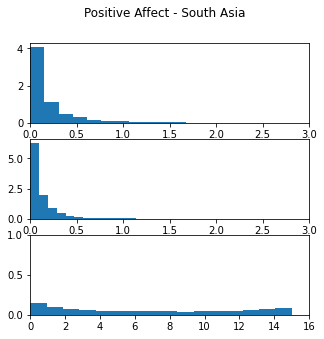

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 27 seconds.
The number of effective samples is smaller than 10% for some parameters.


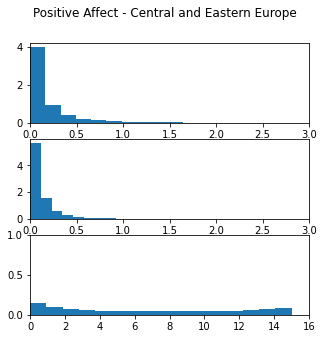

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 26 seconds.
The number of effective samples is smaller than 10% for some parameters.


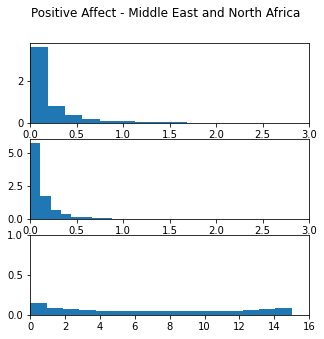

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 24 seconds.
The number of effective samples is smaller than 10% for some parameters.


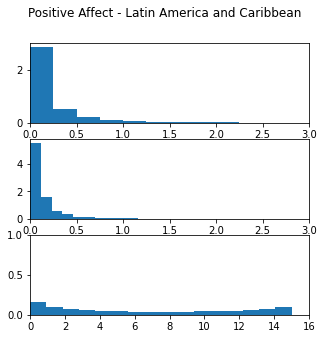

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 29 seconds.
The number of effective samples is smaller than 10% for some parameters.


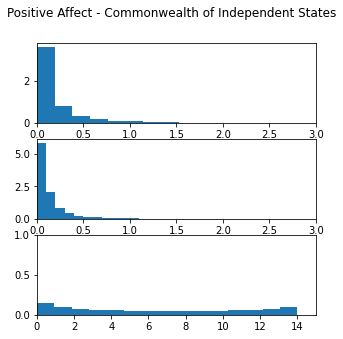

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 25 seconds.
The number of effective samples is smaller than 10% for some parameters.


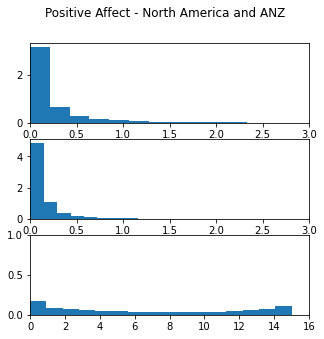

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 24 seconds.
The number of effective samples is smaller than 10% for some parameters.


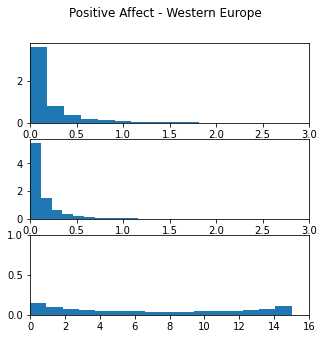

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 24 seconds.
The number of effective samples is smaller than 10% for some parameters.


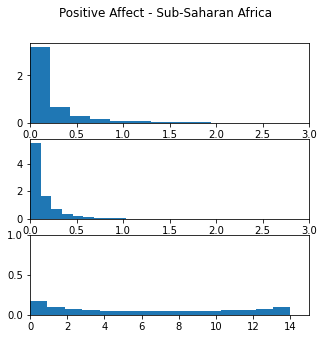

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 34 seconds.
The number of effective samples is smaller than 10% for some parameters.


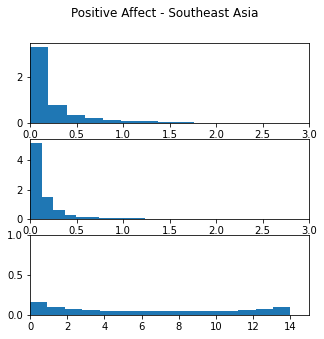

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 33 seconds.
The number of effective samples is smaller than 10% for some parameters.


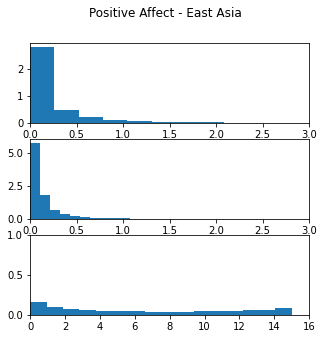

In [331]:
# df_average = df4_historic.groupby("year").mean().reset_index()
df_average = df4_historic.groupby(
    ["year", "regional_indicator"]).median().sort_values("year").reset_index()

for region in df4_historic["regional_indicator"].unique():

    trace, len_data = bayesian_inference(df_average, region, "positive_affect")
    plot_comparison(trace=trace, title=f"Positive Affect - {region}", len_data=len_data)


### 4.2.1. Resumo das respostas

1. Visualização
- Texto
2. Identificação da região do mundo
- Texto
3. Impacto da pandemia
- Texto

# 5.0. DATA PREPARATION

All done in Embedding space section

In [383]:
df5 = df4_historic
df5 = df5.drop(columns=["country_name"], axis=1)

In [384]:
mm = pp.MinMaxScaler()
for variable in df5.columns[1:-1]:  # Numerical columns
    df5[variable] = mm.fit_transform(df5[[variable]])

df5["year"] = pp.OrdinalEncoder().fit_transform(df5[["year"]])
df5["regional_indicator"] = pp.LabelEncoder().fit_transform(
    df5[["regional_indicator"]].values.ravel())

df5.head()


,year,life_ladder,log_gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,regional_indicator
0,3.0,0.238933,0.146579,0.229360,0.412946,0.632975,0.486556,0.892847,0.315063,0.345526,6
1,4.0,0.359097,0.180466,0.375317,0.421875,0.579078,0.508295,0.859462,0.421648,0.303968,6
2,5.0,0.422281,0.201759,0.356315,0.430804,0.470826,0.441015,0.708347,0.476863,0.379256,6
3,6.0,0.258091,0.196338,0.330509,0.437946,0.327588,0.481511,0.734022,0.465803,0.363208,6
4,7.0,0.249448,0.213483,0.329839,0.445089,0.375735,0.552755,0.780971,0.624981,0.364674,6


# 6.0. FEATURE SELECTION

In [385]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test datasets

## 6.2. Feature Selector

### 6.2.1. Best Features

## 6.3. Feature Selection

# 7.0. MACHINE LEARNING MODELLING

In [ ]:
df7 = df6.copy()

## 7.1. Baseline Model

## 7.2. K-Means

In [ ]:
clusters = np.arange(2, 15, 1)

In [ ]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = cluster.KMeans(n_clusters=k, n_init=100, random_state=42)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = metrics.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)


In [ ]:
px.line(x=clusters, y=kmeans_list, markers=True)

## 7.3. Hierarchical Clustering

In [ ]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = metrics.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)


In [ ]:
px.line(x=clusters, y=hc_list, markers=True)

## 7.4. GMM

In [ ]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, n_init=10, random_state=42)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = metrics.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)


In [ ]:
px.line(x=clusters, y=gmm_list, markers=True)

# 8.0. HYPERPARAMETER FINE TUNING


In [ ]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14
KMeans,0.594102,0.547606,0.509844,0.490837,0.448065,0.445412,0.430332,0.400224,0.401725,0.386493,0.405308,0.414599,0.415761
GMM,0.018844,-0.002780,-0.015472,-0.094538,-0.188893,-0.196443,-0.100465,-0.053154,0.003199,0.234662,0.280618,0.393845,0.403136
HC,0.570591,0.531555,0.488917,0.462133,0.459126,0.430972,0.409377,0.396298,0.366189,0.386171,0.404797,0.414088,0.415250


## 8.1. Final Model

# 9.0. ERROR TRANSLATION AND INTERPRETATION


## 9.1. Business Performance

## 9.2. Total Performance

## 9.3. Machine Learning Performance

# 10.0. DEPLOY MODEL TO PRODUCTION


## 10.1. Class Definition

## 10.2. API Handler

## 10.3. API Tester

# Visualization ideas

In [ ]:
# Globe
df_mean = df2_metrics.groupby(
    ['country_name']).mean(['ladder_score']).reset_index()

fig = px.choropleth(
    df_mean, locations='country_name', locationmode="country names", 
    color='ladder_score', projection='orthographic', 
    color_continuous_scale=px.colors.sequential.Viridis,
    range_color=[0, 10],
    title="Positive affect index", 
)

fig.show()

In [ ]:
variable = "generosity"

# df_mean = df2_historic.groupby(
#     ['year','country_name']).mean(
#     [variable]).reset_index()

df_sorted = df2_historic.sort_values("year").reset_index()
fig = px.choropleth(
    df_sorted, locations='country_name', locationmode="country names",
    color=variable, animation_frame='year',
    color_continuous_scale=px.colors.diverging.BrBG,
    range_color=[-1, 1],
    color_continuous_midpoint=0,
    title=f'{variable.capitalize()} time evolution'
)

fig.show()

In [ ]:
variable = "positive_affect"

df_sorted = df2_historic.sort_values("year").reset_index()
fig = px.choropleth(
    df_sorted, locations='country_name', locationmode="country names",
    color=variable, animation_frame='year',
    color_continuous_scale=px.colors.sequential.Viridis,
    range_color=[0.4, 1],
    title=f'{variable.capitalize()} time evolution'
)

fig.show()